# Try implementation two models based on asymmetry  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import sys
sys.path.append('../spock/')
try:
    plt.style.use('paper')
except:
    pass
%matplotlib inline

Start by loading the training data generated with generate_FC_data.ipynb

In [2]:
#load datapath for clean training data that is generated
datapath = '../../cleanData/csvs/resonant/'

dataset = pd.read_csv(datapath+'25-3-25-fillFac.csv')
#remove junk columns
dataset = dataset.drop(columns=['Unnamed: 0','Unnamed: 0.1'])

We can then split the data into training and testing sets, note, we will remove systems that go unstable in 1e4 orbits from the testing set

In [3]:
def train_test(dataset,feat):
    '''divides the dataset into 80% training and 20% testing and returns training/testing sets'''
    Nrows = int(0.8*dataset.shape[0])
    train = dataset.iloc[:Nrows, :]
    test = dataset.iloc[Nrows:, :]
    #remove testing systems that go unstable in short integration phase

    test = test.drop(test[test['InitialStable']==False].index)
    return train[feat], train['Stable'], test[feat], test['Stable'], test['instability_time']

We can then define the features of interest and dividing training and testing sets

In [4]:
near = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear']
far = ['EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar']
megno = ['MEGNO']
# near = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear']
# far = ['EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar']
# megno = ['MEGNO', 'MEGNOstd']
# ['Tsec', '3BRfill', '2BRfillnear', '2BRfillfar']
all = near + far + megno + ['Tsec', '3BRfill', '2BRfillnear', '2BRfillfar']
features = near + far + megno + ['Tsec', '3BRfill', '2BRfillnear']
featuresSym =  near + far + megno + ['Tsec', '3BRfill','2BRfillnear']
featuresAsym = near + far + megno + ['Tsec', '3BRfill', '2BRfillnear']

trainX, trainY, testX, testY, testInstability = train_test(dataset, all)

** Split the training data based on spacing specification **

In [5]:
data = pd.concat([trainX, trainY], axis=1)

In [6]:
spaceL = 1 - (0.7)**(2/3)
#spaceL = 1 - (0.5)**(2/3)
# 0.6 was better than 0.5
# 0. 7 was worse than both


In [7]:
# define where we draw the line when using crossing eccentricity
dataeq = data[(data['EMcrossnear'] < spaceL) | (data['EMcrossfar'] < spaceL)]
datati = data[(data['EMcrossnear'] >= spaceL) & (data['EMcrossfar'] >= spaceL)]


In [8]:
modeleq = XGBClassifier(learning_rate = 0.05, 
                         max_depth = 15, 
                         subsample = 0.95,
                         min_child_weight = 5,
                         n_estimators = 150,
                         )
modeleq.fit(dataeq[featuresSym],dataeq['Stable'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [9]:
modelti = XGBClassifier(learning_rate = 0.05, 
                         max_depth = 15, 
                         subsample = 0.95,
                         min_child_weight = 5,
                         n_estimators = 150,
                         )
modelti.fit(datati[featuresAsym],datati['Stable'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [10]:
model = XGBClassifier(learning_rate = 0.05, 
                         max_depth = 15, 
                         subsample = 0.95,
                         min_child_weight = 5,
                         n_estimators = 150,
                         )
model.fit(data[features],data['Stable'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [11]:
datati

,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,EMcrossfar,EMfracstdfar,EPstdfar,MMRstrengthfar,MEGNO,Tsec,3BRfill,2BRfillnear,2BRfillfar,Stable
3,0.406112,0.036478,0.002390,0.321071,0.427768,0.036219,0.008587,0.012958,2.002493,18313.684674,0.122730,0.040700,0.099440,False
18,0.311123,0.030877,0.002306,3.539114,0.332411,0.108697,0.020162,0.031036,9.258239,19391.692176,0.151884,0.091699,0.061804,False
21,0.312862,0.018244,0.001899,0.406716,0.519564,0.022611,0.002191,NaN,2.006990,44392.691013,0.075038,0.045673,0.028312,True
22,0.302500,0.130498,0.000612,0.536832,0.592106,0.121301,0.000473,2.397928,2.103359,17118.884983,0.014991,0.966787,1.489508,False
26,0.239997,0.030961,0.003348,0.060960,0.279038,0.022397,0.000232,0.069757,15.287776,7008.962106,0.222929,0.971908,0.875319,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81970,0.469471,0.014134,0.004379,NaN,0.586679,0.090598,0.023671,0.838538,34.367543,30964.344562,0.063373,0.692684,NaN,True
81973,0.211867,0.011562,0.000060,0.927665,0.602956,0.001145,0.000095,0.103381,1.984144,13320.032725,0.020810,0.169937,NaN,True
81981,0.405953,0.051913,0.001300,3.764945,0.632315,0.009069,0.005442,0.025920,1.985558,47587.530262,0.016864,0.333092,NaN,True
81992,0.525237,0.051413,0.027555,NaN,0.587843,0.256895,0.061567,0.794928,167.434373,38506.600903,0.052610,1.810895,NaN,False


In [12]:
dataeq

,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,EMcrossfar,EMfracstdfar,EPstdfar,MMRstrengthfar,MEGNO,Tsec,3BRfill,2BRfillnear,2BRfillfar,Stable
0,0.060234,0.029447,0.001995,0.498040,0.504063,0.002900,0.000816,NaN,1.998619,28431.355594,1.917395,8.652930,0.026594,False
1,0.080547,0.016559,0.000112,0.452015,0.240504,0.006736,0.001621,0.008674,2.001688,3904.311701,0.407998,25.825316,0.019346,True
2,0.129660,0.028844,0.003181,1.001973,1.001981,0.001402,0.003742,0.010415,1.995051,70073.695993,0.418203,1.051448,NaN,True
4,0.059897,0.028009,0.001623,0.341814,0.257596,0.053197,0.001287,0.034789,2.029737,4110.203941,2.369149,3.462553,0.239528,False
5,0.062617,0.084135,0.002806,0.041345,0.185250,0.003223,0.000924,0.016763,7.309172,12258.799896,0.979840,1.962447,0.181976,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81990,0.143202,0.056777,0.011075,0.269696,0.218561,0.013075,0.004412,0.054335,1.707679,42018.557120,0.104965,0.110003,0.362808,False
81991,0.118143,0.083684,0.002563,0.104696,0.157872,0.077786,0.010786,0.126476,18.919227,1703.191114,3.526605,1.667883,0.185554,False
81993,0.047094,0.017436,0.000500,0.872209,0.082328,0.158427,0.008790,0.196432,1.928366,3420.172274,1.943687,8.647452,0.632690,False
81994,0.130226,0.036270,0.001641,1.840510,0.693580,0.043583,0.025085,NaN,1.995337,2990.010409,0.536070,15.288754,NaN,True


# tight systems

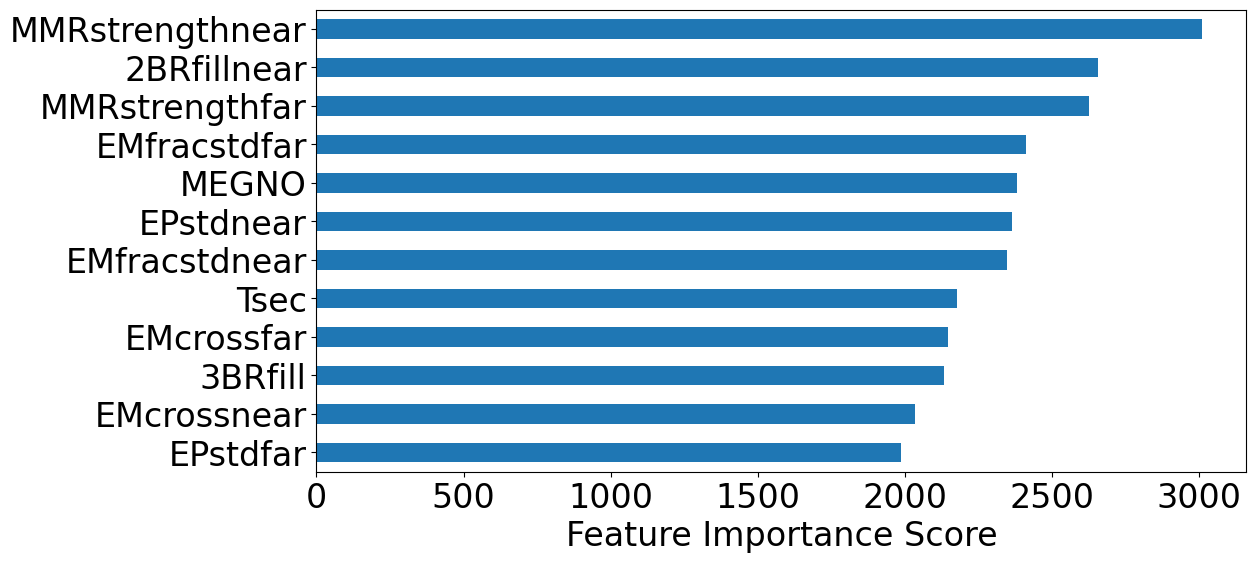

In [13]:
feat_imp = pd.Series(modelti.get_booster().get_fscore()).sort_values(ascending=False)
ax = feat_imp.plot.barh(figsize=(12,6), fontsize=24)
ax.set_xlabel('Feature Importance Score', fontsize=24)
ax.invert_yaxis()

# equal systems

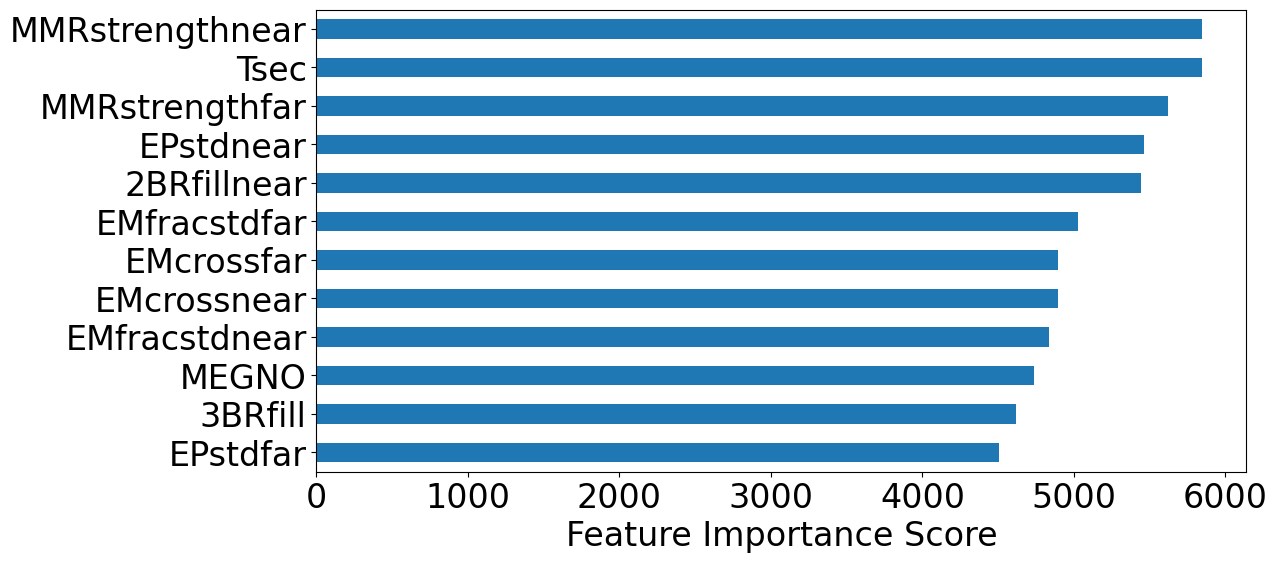

In [14]:
feat_imp = pd.Series(modeleq.get_booster().get_fscore()).sort_values(ascending=False)
ax = feat_imp.plot.barh(figsize=(12,6), fontsize=24)
ax.set_xlabel('Feature Importance Score', fontsize=24)
ax.invert_yaxis()

# All systems (all model)

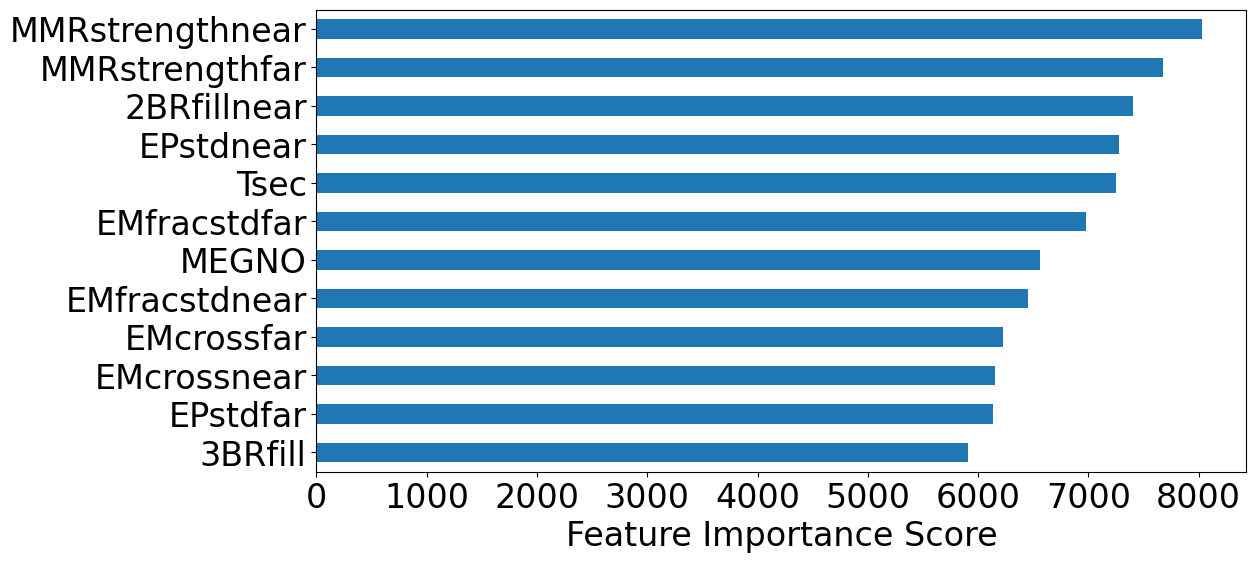

In [15]:
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
ax = feat_imp.plot.barh(figsize=(12,6), fontsize=24)
ax.set_xlabel('Feature Importance Score', fontsize=24)
ax.invert_yaxis()

# now try on testing

In [16]:
from sklearn import metrics
from sklearn.metrics import roc_curve, confusion_matrix, auc
def altROC_curve( x,y):
    global spaceL
    data = pd.concat([x, y], axis=1)
    dataeq = data[(data['EMcrossnear'] < spaceL) | (data['EMcrossfar'] < spaceL)]
    datati = data[(data['EMcrossnear'] >= spaceL) & (data['EMcrossfar'] >= spaceL)]
    predseq = modeleq.predict_proba(dataeq[featuresSym])[:,1]
    predsti = modelti.predict_proba(datati[featuresAsym])[:,1]
    preds = np.concatenate((predseq,predsti))
    dy = np.concatenate((np.array(dataeq['Stable']), np.array(datati['Stable'])))
    fpr, tpr, ROCthresholds = roc_curve(dy, preds)
    roc_auc = metrics.roc_auc_score(dy, preds)
    return roc_auc, fpr, tpr, ROCthresholds

In [21]:
def ROC_curve( model, x,y):
    preds = model.predict_proba(x[features])[:,1]
    fpr, tpr, ROCthresholds = roc_curve(y, preds)
    roc_auc = metrics.roc_auc_score(y, preds)
    return roc_auc, fpr, tpr, ROCthresholds

In [22]:
np.array(dataeq['Stable'])

array([False,  True,  True, ..., False,  True, False])

Text(0.5, 1.0, '(AUC = 0.9547)')

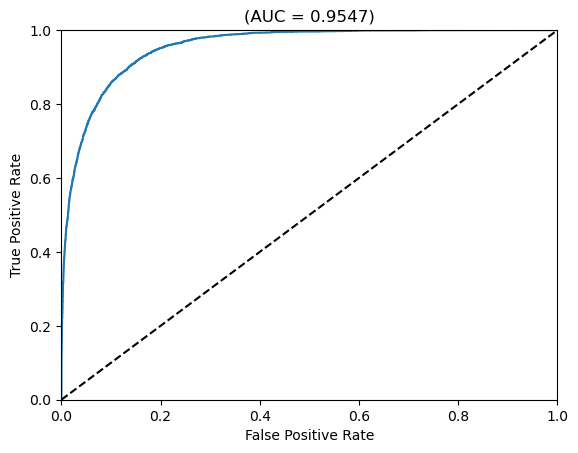

In [23]:
roc_auc, fpr, tpr, ROCthresholds = altROC_curve(testX, testY)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('(AUC = {0:.4f})'.format(roc_auc))


Text(0.5, 1.0, '(one model AUC = 0.9551)')

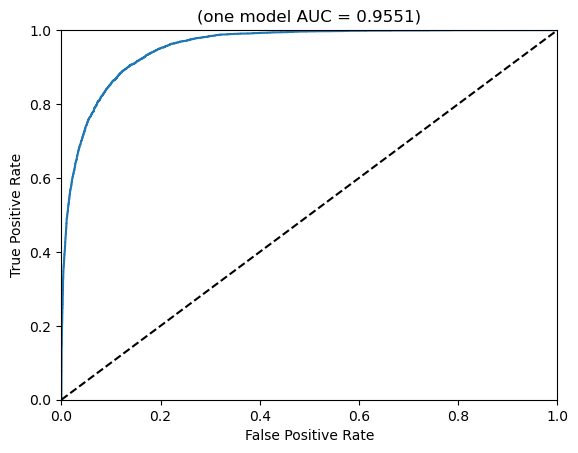

In [24]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(model, testX, testY)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('(one model AUC = {0:.4f})'.format(roc_auc))